# Toxicity Classification of Parler Data 

## Background:
Since the Jan 6th attack on the capital, extremism is ever more important to detect and act on.
Parler chat data has been made available to various interested parties and has been archived for use.

The parler data is inherently unlabeled, thus different strategies can be employed to further the accurate classification of toxicity on this dataset.

## Approach

I'm opting for a semi-supervised learning process.

##### Delta training
Taking the most confident model predictions to leak into the training set.. Though it is acknowledged there is bias in this approach.
##### Parler word vectors
Another approach is to evaluate how word vectors trained on parler data can improve classification.
##### Heuristics for predictions on unlabeled data
Additional Heuristics are needed to properly gauge/identify predictions on unlabeled parler data.


## Steps

##### Init Model
Initialize a model using labeled data from jigsaw-toxic-comment-classification
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview
##### Data Wrangling
Use work from d0nk to obtain a 2gb set of parler posts
https://github.com/d0nk/parler-tricks

Used modules from sbooeshaghi's git repo to process the 2GB sample
parler data https://github.com/sbooeshaghi/parlertrick/blob/main/parler.ipynb
##### Embeddings:
Combine parler, toxic tweet, and other data to create a common word vector
using GloVe from stanfordnlp
https://github.com/stanfordnlp/GloVe
##### Data Augmentation via text generation
Use textgenrnn made by minimaxir to generate toxic samples trained from test set according to specific labels
https://github.com/minimaxir/textgenrnn






Please reach out to medisp@icloud.com to collaborate

In [299]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
pd.set_option('expand_frame_repr', False)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [300]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [301]:
from tensorflow.python.client import device_lib

In [302]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7553863646481222494
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2251253350
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13439922086561430166
physical_device_desc: "device: 0, name: GeForce GTX 780 Ti, pci bus id: 0000:03:00.0, compute capability: 3.5"
]


In [303]:
import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.3.1


### Set attributes and load data

In [304]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 200      # embedding dimensions for word vectors (word2vec/GloVe)
#GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

train = pd.read_csv('labeled_data/train.csv' ) # , header=0, sep=',', quotechar='"')
test = pd.read_csv('labeled_data/test.csv' ) # , header=0, sep=',', quotechar='"')
labels_test = pd.read_csv('labeled_data/test_labels.csv' ) # , header=0, sep=',', quotechar='"')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

y = train[labels].values
comments_train = train['comment_text']
comments_train = list(comments_train)

# According to https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/55975
# labels of -1 weren't used in scoring and are not actually labels

labels_test = labels_test[(labels_test[labels] != -1).any(axis=1)]
test = test.iloc[labels_test.index]
test_y = labels_test[labels].values

### Text processing

In [305]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'\W+',' ',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output)

In [306]:
clean_text('Could not be more clear',False)

'could not be more clear'

In [ ]:
# texts = [] 

# for line in comments_train: 
#     texts.append(clean_text(line))
# print('Sample data:', texts[1], y[1])

### Save processed text
Takes an hour or so

In [ ]:
# with open('text_files/train_cleansed_text.txt', 'w', encoding="utf-8") as filehandle:
#     filehandle.writelines("%s\n" % line for line in texts)

In [307]:
# read in saved cleansed training test as a list
# define empty list
texts = []
# open file and read the cleansed texts
with open('text_files/train_cleansed_text.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        texts.append(current_place)

### Create Tokenizers and Sequences

Using a word level tokenizer 

In [308]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 207546


### Pad Sequences and view tensor shapes

In [309]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


### Shuffle Data

In [310]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

### Split Training and Validation data

In [311]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of samples in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of samples in each category:
training:  [12220  1304  6720   394  6294  1149]
validation:  [3074  291 1729   84 1583  256]


In [312]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 3118  5587 31000  5587 22080    72     3  1400  3118  5587 31000    27
  5587 22080   835  5587 31000    34   515  5587 22080  9844   269   215
 75111   136  2846  1200   152  4884   131  2459  4687     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

### Word Vectors
set initial baseline by using twitter 200B word vectors

Observe for improvement by using parler + train + test data

In [313]:
# Using Twitter 200B word vectors
embeddings_index = {}
GLOVE_DIR = "glove_vectors/glove.twitter.27B."+str(EMBEDDING_DIM)+"d.txt"
#GLOVE_DIR = "glove/vectors.txt"
f = open(GLOVE_DIR, errors = 'ignore' , encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_vectors/glove.twitter.27B.200d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


### Create Model

The model uses an input layer bounded by sequence length of the texts. Issues may arise when long text samples are sent for prediction.

The embedding layer is initialized via weights from word vectors

LSTM Cell with 60 units with return sequences = True, returning values from each time/sequence step.

Max pooling to capture most important time step

Dropout layer

Dense layer with rectified linear unit activation

Dropout layer 2

Sigmoid final layer to give probabilities of each class (6)


TODO: 
- Skip connections? 
- Lasso(l1) or Ridge (l2) regularization
- dropout tuning
- 2 different embeddings with concatenation before LSTM

In [314]:
#  input --> embedding --> lstm 60 cell --> pooling --> dropout --> dense --> drop --> final dense

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

### Compile Model

Instantiating model with input and output
compiling model using binary cross entropy loss, and adam optimizer

TODO: ADAM learning rate + learning rate decay


In [315]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [316]:
import keras
import pydot
import pydotplus
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot


### Model Visualization

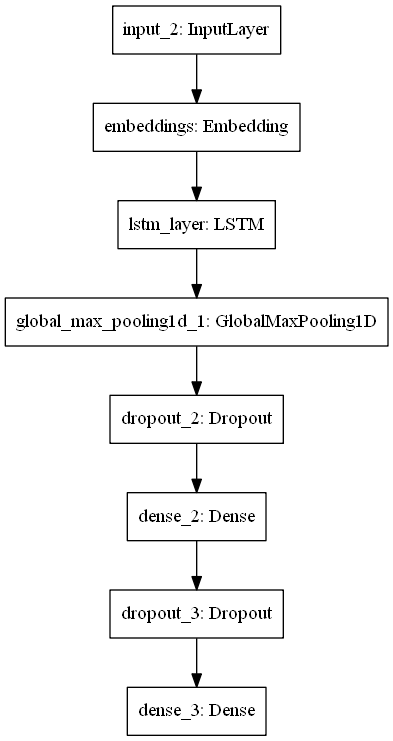

In [317]:
plot_model(model)


In [318]:
model.summary() 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 200)          41509400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

### Keras callbacks mid epoch

In [319]:
filepath = "models/toxic-classifier/tc-gpu-v0.05-200emb-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                             factor=0.2,
                             patience=2,
                             min_lr=0.0001)

early_stopping = EarlyStopping(monitor='accuracy',
                              patience=6
                              )

### Execute Training

In [320]:
print('Training progress:')
history = model.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size=1024, 
                    validation_data=(x_val, y_val), 
                    callbacks= [reduce_lr,
                               early_stopping])

Training progress:
Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.2445WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000027FD6E961E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTO

In [321]:
model.save('models/toxic-classifier/tc-gpu-v0.05-200emb.hdf5')

### Evaluation

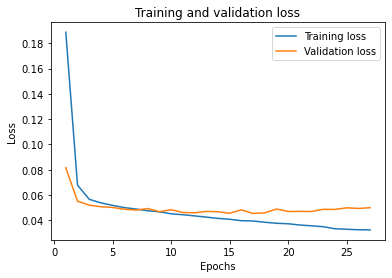

In [322]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();


#### Process and encode test input

In [ ]:
test_cleansed_text = list(test.apply(lambda x: clean_text(x.comment_text), axis=1))

In [ ]:
with open('text_files/test_cleansed_text.txt', 'w', encoding="utf-8") as filehandle:
    filehandle.writelines("%s\n" % line for line in test_cleansed_text)

In [324]:
# Reading in saved test cleansed text as a list
test_cleansed_text = []
# open file and read the cleansed texts
with open('text_files/test_cleansed_text.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        test_cleansed_text.append(current_place)

In [325]:
encoded_input = tokenizer.texts_to_sequences(test_cleansed_text)

In [326]:
enc_data = pad_sequences(encoded_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [327]:
test_preds = model.predict(enc_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Compute stats metrics

In [328]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

def calc_auc(y_true,y_pred):
     return np.mean([roc_auc_score(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])
    
def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])

def roc_auc_score_multiclass(y_true, y_pred, average = "macro"):
    roc_auc_dict = {}
  # iterate through labels
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for i,label in enumerate(labels):
        #using the sklearn metrics method to calculate the roc_auc_score
        try:
            roc_auc = roc_auc_score(y_true[:,i], y_pred[:,i], average = average)
        except:
            roc_auc = 0
        roc_auc_dict[label] = roc_auc

    return roc_auc_dict

In [329]:
print("AUC      {:10.4f}".format(calc_auc(test_y,test_preds)))
print("Log Loss {:10.4f}".format(calc_loss(test_y,test_preds)))
roc_auc_score_multiclass(test_y,test_preds)

AUC          0.9774
Log Loss     0.0754


{'toxic': 0.9634032219853115,
 'severe_toxic': 0.9885466787079523,
 'obscene': 0.9769167253915308,
 'threat': 0.9838606740460698,
 'insult': 0.9710725081101222,
 'identity_hate': 0.9807164515296038}

In [330]:
model.evaluate(enc_data,test_y)

2000/2000 [==============================] - 23s 12ms/step - loss: 0.0754 - accuracy: 0.9966


[0.07540770620107651, 0.9966394901275635]

### Per Class Stats

In [331]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(y_true, y_pred):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    y_true (np.array): a multi-class array of the true values with shape (len(y_true),num_classes)
    @params    y_pred (np.array): a multi-class array of predicted probabilities with shape (len(y_true), num_classes)
    """
    fpr = {}
    tpr = {}
    threshold = {}
    roc_auc = {}
    accuracy = {}
    for i,label in enumerate(labels):
        fpr[label], tpr[label], threshold[label] = roc_curve(y_true[:,i], y_pred[:,i])
        print('Stat Metrics: {}'.format(label))
        roc_auc[label] = auc(fpr[label], tpr[label])
        print(f'AUC: {roc_auc[label]:.4f}')

        # Get accuracy over the test set
        y_delt = np.where(y_pred[:,i] >= 0.5, 1, 0)
        accuracy = accuracy_score(y_true[:,i], y_delt)
        print(f'Accuracy: {accuracy*100:.2f}%')

        # Plot ROC AUC
        plt.title('Receiver Operating Characteristic: {}'.format(label))
        plt.plot(fpr[label], tpr[label], 'b', label = 'AUC = %0.2f' % roc_auc[label])
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [332]:
evaluate_roc(test_y,test_preds)

TypeError: unhashable type: 'numpy.ndarray'

### Loading Parler Data

In [15]:
parler_df = pd.read_csv('out.zip', compression='zip', header=0, sep=',', quotechar='"')

In [16]:
from pandas_profiling import ProfileReport

In [17]:
profile = ProfileReport(parler_df, title="Parler Profiling Report")

In [18]:
profile.to_widgets()
# takes 6 mins or so

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
parler_df = parler_df.dropna()
parler_df = parler_df.drop_duplicates(subset=['post_text'])
#df_inf = df_inf.reset_index(drop=True)

In [21]:
parler_df

,author_name,author_username,author_profile_photo,post_text,post_image,post_timestamp,post_impressions
47941,Truth4Americans,@David52,https://images.parler.com/5e9347927d3f43f3ab9276b58d6037b3_256,Could not be more clear,https://api.parler.com/l/mJbTY,5 days ago,"22,804.00"
47942,David Vance,@DavidVance,https://images.parler.com/dc63e4422a2f442495670d1dabe7d6f5_256,Seen THIS?,https://api.parler.com/l/wPSf6i,4 days ago,"112,283.00"
47943,Name Hidden,@Private User,https://company-media.parler.com/par-default-profile-picture.jpg,"Please share this photo. This women assaulted a Trump supporter busting her eye open and ran away. She was wearing an “Admiral Security Services” jacket so it seems she works for them. The closest Admiral Security places in DC are either in Bethesda, MD or Baltimore, MD",https://api.parler.com/l/QDxIr,5 days ago,"311,964.00"
47946,Sunstepan,@Sunstepan,https://images.parler.com/e83211ff673b47dabb7b63d2562064a9_256,Os brasileiros estão assim... Acorda povo...,https://api.parler.com/l/NRS22,4 days ago,208.00
47947,KAGBABE,@kagbabe,https://images.parler.com/58d4de64b5204d28a975127e0489f853_256,"Last screen shot before bed, also fuck Brian Kemp, Brad Raffensperger, Gabriel Sterling, Geoff Duncan and every single RINO",https://api.parler.com/l/imZUJ,4 days ago,"19,300.00"
...,...,...,...,...,...,...,...
1854089,Sasquatch1791,@sasquatch1791,https://images.parler.com/45af781537244849a689693e5fb7e18c_256,#jihadoncapitolhill #stormthecapitol #memes #funny #humor #2021 #fallout #falloutnewvegas #fallout NV #gaming,https://api.parler.com/l/uybeU,4 days ago,"2,067.00"
1854196,SteveDeace,@SteveDeace,https://images.parler.com/9c920e26468544edbb4aee3b1dcee54c_256,Who did this?,https://api.parler.com/l/JP2p3,1 month ago,"62,855.00"
1854250,BlackRant,@BlackRant,https://images.parler.com/51197c9c22cb43c680e1746f9329d1b3_256,"That’s why we have problems we have today with Bill Gates and the “Great Reset”. The Nazis weren’t ended, just rebranded.",https://api.parler.com/l/QWmMQ,5 days ago,607.00
1854260,Emikko39,@Emikko39,https://images.parler.com/d1003667ac984cff98ff051c65dc22f8_256,I made it!Hang in there!#maga,https://api.parler.com/l/Xk0Io,4 days ago,193.00


In [ ]:
df_inf = parler_df.sort_values(by=['post_impressions'], ascending=False, na_position='last')[:20000]
df_inf = df_inf.reset_index(drop=True)

In [22]:
# Cleanse post text
# cleansed_post_text = df_inf.apply(lambda x: clean_text(x.post_text), axis=1)

# read in saved cleansed parler text as a list

cleansed_parler_text = []
# open file and read the cleansed texts
with open('text_files/cleansed_parler.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        cleansed_parler_text.append(current_place)

In [24]:
len(cleansed_parler_text)

47691

In [26]:
print('Sample inference data:', cleansed_parler_text[6])

Sample inference data:  america home brave america home strong begun fight want push us dems doomed freedom americabecausefuckyou warriors fight dosomething nofear win


In [27]:
encoded_input = tokenizer.texts_to_sequences(cleansed_parler_text)

In [28]:
len(encoded_input)

47691

In [29]:
enc_data = pad_sequences(encoded_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [32]:
model_tc_twittervecs = tf.keras.models.load_model('models/toxic-classifier/tc-gpu-v0.05-200emb.hdf5')

In [33]:
model_tc_twittervecs.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 200)          41509400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0   

In [34]:
inf_results = model_tc_twittervecs.predict(enc_data)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [35]:
len(inf_results)

47691

### Adding Prediction Labels to parler df

In [38]:
pred_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [45]:
parler_df = parler_df.reset_index(drop=True)
for i, result_array in enumerate(inf_results):
    for j,label in enumerate(pred_labels):
        parler_df.at[i,label] = result_array[j]
        #df_inf.set_value(i,label , result_array[j])

### Eyeballing Results of inference

Warning: The text in this data contains graphic content and may be upsetting to some people.
In light of this, sorting by least toxic of the labels in order to spot false positives may be a more palatable strategy

In [52]:
view = parler_df.sort_values(by=pred_labels, ascending=True, na_position='last')[['author_name','post_text','post_impressions','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']][:200]

In [53]:
view

,author_name,post_text,post_impressions,toxic,severe_toxic,obscene,threat,insult,identity_hate
47256,Bill Mitchell • Save the Republic!,"When all the votes in Fulton and DeKalb Counties are counted, they will have almost as many votes in a Special Election as in a Presidential Election!","40,953.00",0.00,0.00,0.00,0.00,0.00,0.00
13089,Jpjoynson,"Once again if you try to share a picture of a document from the Senate of Pennsylvania saying that there was indeed Election Irregularities Facebook won't let you share that to Parler. I've noticed this going on for Months and it's on Conservative Posts usually and not all content only the content of certain posts. You can try and share it by the copy option in the top right or copy to clipboard, share to Parler or even try to copy to Gmail then copy and paste the link there and bring it in to Parler all fail. It will either say redirecting or Log In To Facebook. Everyone start looking to see if this is actually the case for others please. Thanks!","1,180.00",0.00,0.00,0.00,0.00,0.00,0.00
40962,MABVET,Thread by @KanekoaTheGreat on Thread Reader App – Thread Reader App On Italygate interference in US election,301.00,0.00,0.00,0.00,0.00,0.00,0.00
3151,Danny C,"IS THIS THE ONLY DATE IN THE US CONSTITUTION THAT IS FINAL? 🐸 WWG1WGA The Twentieth Amendment (Amendment XX) to the United States Constitution moved the beginning and ending of the terms of the president and vice president from March 4 to January 20, and of members of Congress from March 4 to January 3.","1,784.00",0.00,0.00,0.00,0.00,0.00,0.00
26285,Yoda,"Posts circulating on social media allege that “only 133 million registered voters voted” to falsely claim that the number of votes cast for Joe Biden is not mathematically possible. The calculation on which this claim is based on is misleading. The nationwide voter turnout is usually calculated using the eligible-voting population as a denominator, not the number of registered voters. Around 239,247,182 people were eligible to vote in 2020. While there is no available figure yet for nationwide registered voters for 2020, Reuters calculations found there were an estimated 206,557,583 registered voters as of the publication of this article.Published 1 Jan 2021","1,122.00",0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
22880,Blessing Joseph,All this people came out for Trump the legitimate winner of U.S. presidential election. Pro Trump #stopthecoup #stopthesteal protests is ongoing now in Washington D.C. The main Protest will be starting tomorrow against the rigging of united state presidential election.Not even one third of this population has ever turn up for Biden once since 1947 he came in to politics.,580.00,0.00,0.00,0.00,0.00,0.00,0.00
45994,Name Hidden,The important item in this photo is the parking sign. The key words are VIRGIN BEACH DEVELOPMENT AUTHORITY. I'll explain next post...,6.00,0.00,0.00,0.00,0.00,0.00,0.00
20143,Activated,"A few hours ago, the President's and head of social media, Dan Scavino, posted this cryptic photograph, with three words (""sir"", ""game,"" ""activation"") under three people, respectively: the one who appears to be the vice president , a cabinet member with a computer, and Trump himself. We could infer that the President has activated the game, and that game has to do with the traitorous vice president, who appears obscured, and in the background. Attention to the following messages from the secretary of state, Pompeo.","3,568.00",0.00,0.00,0.00,0.00,0.00,0.00
26768,RSBN 🇺🇸,"Good Morning from Carson City, NV. Join us later today at 12pm for a ‘Trump Campaign and Nevada Republican Presidential Electors Major Announcement’. 🎥 #rightsidebroadcastingnetwork #nevadaelection #trump2020","213,689.00",0.00,0.00,0.00,0.00,0.00,0.00


### Determining a threshold to create the best separation 

In [201]:
parler_threshold = parler_df[(parler_df[pred_labels] <= 0.01).all(axis=1)]

In [180]:
parler_threshold[["post_text"]+pred_labels]

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Could not be more clear,0.00,0.00,0.00,0.00,0.00,0.00
2,"Please share this photo. This women assaulted a Trump supporter busting her eye open and ran away. She was wearing an “Admiral Security Services” jacket so it seems she works for them. The closest Admiral Security places in DC are either in Bethesda, MD or Baltimore, MD",0.00,0.00,0.00,0.00,0.00,0.00
6,"America, home of the brave. America, home of the strong!We have just begun to fight. You want to push us? Dems are doomed!#freedom #Americabecausefuckyou #warriors #fight #doSomething #NOFEAR #win",0.01,0.00,0.00,0.00,0.00,0.00
7,"Please read the message below carefully. We have ONE President at a time. Our President is Donald J. Trump.When President Trump speaks, listen carefully.",0.00,0.00,0.00,0.00,0.00,0.00
13,Ashli Babbitt.14 year veteranPatriotKilled at the Capitol today.,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
47682,"Further proof that President Donald Trump won. The media is trying for a color revolution, a coup.",0.00,0.00,0.00,0.00,0.00,0.00
47683,"The definition of insanity is doing the same thing over and over and expecting a different result. Give me a break, they use the same machines the same tactics and they got their same result. THE QUESTION IS: What are we gonna do about it",0.00,0.00,0.00,0.00,0.00,0.00
47685,HOLD THE LINE!!!!!! NEVER GIVE UP!!!!!!!,0.00,0.00,0.00,0.00,0.00,0.00
47686,#jihadoncapitolhill #stormthecapitol #memes #funny #humor #2021 #fallout #falloutnewvegas #fallout NV #gaming,0.00,0.00,0.00,0.00,0.00,0.00


In [185]:
parler_threshold.to_csv('pandas_dfs/parler_threshold.csv', index = True, sep=',', quotechar='"')

In [198]:
parler_threshold = pd.read_csv('pandas_dfs/parler_threshold.csv', index_col=0, sep=',', quotechar='"')

### Comments
A problem with this approach arises when missed classifications that are egregiously threatening aren't propagated to the sample.

A way to check this is to create a hold-out set from this, and train on the remainder.
We return to this hold-out set with a model trained on that remainder.
We can then check if the model was able to learn more from this body of toxic text to flag things that are missed.
Setting a strong threshold will let us eyeball any missed predictions.


In [202]:
training_leakage = parler_df.drop(parler_threshold.index)

In [204]:
training_leakage

,author_name,author_username,author_profile_photo,post_text,post_image,post_timestamp,post_impressions,0,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,David Vance,@DavidVance,https://images.parler.com/dc63e4422a2f442495670d1dabe7d6f5_256,Seen THIS?,https://api.parler.com/l/wPSf6i,4 days ago,"112,283.00",nan,0.03,0.00,0.00,0.00,0.00,0.00
3,Sunstepan,@Sunstepan,https://images.parler.com/e83211ff673b47dabb7b63d2562064a9_256,Os brasileiros estão assim... Acorda povo...,https://api.parler.com/l/NRS22,4 days ago,208.00,nan,0.02,0.00,0.01,0.00,0.00,0.00
4,KAGBABE,@kagbabe,https://images.parler.com/58d4de64b5204d28a975127e0489f853_256,"Last screen shot before bed, also fuck Brian Kemp, Brad Raffensperger, Gabriel Sterling, Geoff Duncan and every single RINO",https://api.parler.com/l/imZUJ,4 days ago,"19,300.00",nan,0.92,0.02,0.86,0.01,0.19,0.00
5,Conservative State,@ConservativeState,https://images.parler.com/84320cc94ccc4b239d9d9536c02c142e_256,President Trump trying to keep Republic alive #save The USA,https://api.parler.com/l/FMNvm,4 days ago,"207,188.00",nan,0.19,0.00,0.01,0.02,0.02,0.01
8,Tamee 🇺🇸,@Tamee,https://images.parler.com/2b75d42759f046719d04a1b4afe46c1e_256,"Real eyes, realize, real lies #1984 #dopeopleknowhistory #historyrepeatsitself #totalitarianism #tyranny #bigbrother #readahistorybook",https://api.parler.com/l/Tj7T4,2 weeks ago,241.00,nan,0.08,0.00,0.00,0.00,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47680,☄💫🔥T1969W🔥💫☄,@WiseEnough,https://images.parler.com/25d93d87698c450abcb5860b1b203368_256,@trump,https://api.parler.com/l/ADGWt,4 days ago,406.00,nan,0.01,0.00,0.00,0.00,0.00,0.00
47684,BLACKS FOR TRUMP,@AdeniranDeji,https://images.parler.com/ef05329169234e5fa4c29c2de6e4b6a8_256,"🚨🚨🚨🚨Congress is being told to ""shelter in place"" as protestors have breached police lines and entered the Capitol building.How do you like being on lockdown, you fucking bastards?!#FightBack #FightLikeAFlynn🚨🚨",https://api.parler.com/l/Sz3Ch,4 days ago,"10,856.00",nan,0.99,0.02,0.96,0.00,0.75,0.00
47687,SteveDeace,@SteveDeace,https://images.parler.com/9c920e26468544edbb4aee3b1dcee54c_256,Who did this?,https://api.parler.com/l/JP2p3,1 month ago,"62,855.00",nan,0.05,0.00,0.01,0.00,0.01,0.00
47689,Emikko39,@Emikko39,https://images.parler.com/d1003667ac984cff98ff051c65dc22f8_256,I made it!Hang in there!#maga,https://api.parler.com/l/Xk0Io,4 days ago,193.00,nan,0.02,0.00,0.00,0.00,0.00,0.00


### ~5k new data points using threshold of 0.5 

Using this set, we will split 1k as holdout2 and use 4k for training


In [205]:
toxic_parler_subset = training_leakage[(training_leakage[pred_labels] >= 0.5).any(axis=1)]

In [207]:
len(toxic_parler_subset)

5057

In [217]:
toxic_parler_train = toxic_parler_subset[["post_text"]+pred_labels]

In [218]:
toxic_parler_train

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
4,"Last screen shot before bed, also fuck Brian Kemp, Brad Raffensperger, Gabriel Sterling, Geoff Duncan and every single RINO",0.92,0.02,0.86,0.01,0.19,0.00
15,Even Jesus won't forgive you for what you've done you soulless pussy!!!!,0.93,0.03,0.73,0.02,0.38,0.02
34,Staged‼️I am getting sick to my somach,0.66,0.00,0.06,0.04,0.11,0.01
53,"Traitor Matt Drudge crawled out from under his rock again. (The race hasn't been called yet, and anything could happen).",0.58,0.00,0.06,0.00,0.12,0.01
59,ANTIFA unloaded from buses with Tags and all!!!!Completely organized!!!!! PENCE is a TRAITOR!!!,0.65,0.00,0.04,0.00,0.20,0.02
...,...,...,...,...,...,...,...
47662,Another Anti Trump wanker 👇,0.55,0.00,0.06,0.01,0.17,0.04
47665,"Bunch of morons paying quadruple what we pay to own land in safe, clean, peaceful places...calling US the backwards rednecks. Just LOL.",0.85,0.01,0.13,0.01,0.50,0.04
47674,"▶️ The Fat Lady Sang.▶️ WHOSE FAULT? Trump, His Advisors, Gold Badge Accounts, Qanon, Social media team.▶️ Trump will never run again. It's over.#Georgia #Election #StoptheSteal #Biden #Pardon @TeamTrump@TedCruz @JimJordan @GenFlynn contact me idiots.",0.92,0.00,0.17,0.00,0.52,0.01
47676,Another wanker 👇,0.90,0.03,0.58,0.01,0.44,0.02


In [221]:
for label in pred_labels:
    toxic_parler_train[label].loc[toxic_parler_train[label] > 0.5] = 1
    toxic_parler_train[label].loc[toxic_parler_train[label] < 0.5] = 0

C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\medisp\Miniconda3\envs\keras\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._

In [222]:
toxic_parler_train

,post_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
4,"Last screen shot before bed, also fuck Brian Kemp, Brad Raffensperger, Gabriel Sterling, Geoff Duncan and every single RINO",1.00,0.00,1.00,0.00,0.00,0.00
15,Even Jesus won't forgive you for what you've done you soulless pussy!!!!,1.00,0.00,1.00,0.00,0.00,0.00
34,Staged‼️I am getting sick to my somach,1.00,0.00,0.00,0.00,0.00,0.00
53,"Traitor Matt Drudge crawled out from under his rock again. (The race hasn't been called yet, and anything could happen).",1.00,0.00,0.00,0.00,0.00,0.00
59,ANTIFA unloaded from buses with Tags and all!!!!Completely organized!!!!! PENCE is a TRAITOR!!!,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
47662,Another Anti Trump wanker 👇,1.00,0.00,0.00,0.00,0.00,0.00
47665,"Bunch of morons paying quadruple what we pay to own land in safe, clean, peaceful places...calling US the backwards rednecks. Just LOL.",1.00,0.00,0.00,0.00,0.00,0.00
47674,"▶️ The Fat Lady Sang.▶️ WHOSE FAULT? Trump, His Advisors, Gold Badge Accounts, Qanon, Social media team.▶️ Trump will never run again. It's over.#Georgia #Election #StoptheSteal #Biden #Pardon @TeamTrump@TedCruz @JimJordan @GenFlynn contact me idiots.",1.00,0.00,0.00,0.00,1.00,0.00
47676,Another wanker 👇,1.00,0.00,1.00,0.00,0.00,0.00


In [226]:
parler_train = list(toxic_parler_train.apply(lambda x: clean_text(x.post_text), axis=1))

In [227]:
parler_y = toxic_parler_train[pred_labels].values

In [236]:
parler_train = list(parler_train)

In [238]:
parler_train_append = parler_train[:4000]

In [239]:
parler_y_append = parler_y[:4000]

In [240]:
parler_y_append.shape

(4000, 6)

In [241]:
parler_x_holdout = parler_train[4000:]

In [242]:
parler_y_holdout = parler_y[4000:]

In [290]:
parler_y_holdout.shape

(1057, 6)

### Combining texts with parler_train, y with parler_y

In [231]:
len(texts)

159571

In [246]:
# 3 duplicates
texts.extend(parler_train_append)
texts.extend(parler_train_append)
texts.extend(parler_train_append)

In [247]:
len(texts)

171571

In [261]:
y_list = list(y)
y_list.extend(list(parler_y_append))
y_list.extend(list(parler_y_append))
y_list.extend(list(parler_y_append))

In [252]:
list(y).extend(list(parler_y_append))
list(y).extend(list(parler_y_append))
list(y).extend(list(parler_y_append))

In [263]:
len(y_list)

171571

In [264]:
y1 = np.array(y_list)

In [265]:
y1.shape

(171571, 6)

### Copied Code from Above to retrain

In [267]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 211814


In [268]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (171571, 200)
Shape of label tensor: (159571, 6)


In [270]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y1[indices]

In [271]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of samples in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of samples in each category:
training:  [21850.  1320. 10701.   415.  9542.  1227.]
validation:  [5444.  362. 2659.  114. 2424.  334.]


In [272]:
# Using Twitter 200B word vectors
embeddings_index = {}
GLOVE_DIR = "glove_vectors/glove.twitter.27B."+str(EMBEDDING_DIM)+"d.txt"
#GLOVE_DIR = "glove/vectors.txt"
f = open(GLOVE_DIR, errors = 'ignore' , encoding="utf8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

#  input --> embedding --> lstm 60 cell --> pooling --> dropout --> dense --> drop --> final dense

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

Loading GloVe from: glove_vectors/glove.twitter.27B.200d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [273]:
model_parler = Model(sequence_input, preds)
model_parler.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [294]:
model_parler.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 200)          42363000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           62640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [295]:
filepath = "models/toxic-classifier/parler-classifier-gpu-v0.05-200emb-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='accuracy',
                             factor=0.2,
                             patience=2,
                             min_lr=0.0001)

early_stopping = EarlyStopping(monitor='accuracy',
                              patience=6
                              )
print('Training progress:')
history = model_parler.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size=1024, 
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr,
                               early_stopping])
model_parler.save('models/toxic-classifier/parler-classifier-gpu-v0.05-200emb.hdf5')


Training progress:
Epoch 1/30
135/135 [==============================] - 26s 193ms/step - loss: 0.1799 - accuracy: 0.9947 - val_loss: 0.1849 - val_accuracy: 0.9942
Epoch 2/30
135/135 [==============================] - 26s 193ms/step - loss: 0.1799 - accuracy: 0.9947 - val_loss: 0.1850 - val_accuracy: 0.9942
Epoch 3/30
135/135 [==============================] - 27s 198ms/step - loss: 0.1798 - accuracy: 0.9947 - val_loss: 0.1850 - val_accuracy: 0.9942
Epoch 4/30
135/135 [==============================] - 26s 193ms/step - loss: 0.1796 - accuracy: 0.9947 - val_loss: 0.1852 - val_accuracy: 0.9942
Epoch 5/30
135/135 [==============================] - 27s 197ms/step - loss: 0.1796 - accuracy: 0.9947 - val_loss: 0.1853 - val_accuracy: 0.9942
Epoch 6/30
135/135 [==============================] - 26s 192ms/step - loss: 0.1795 - accuracy: 0.9947 - val_loss: 0.1853 - val_accuracy: 0.9942
Epoch 7/30
135/135 [==============================] - 26s 191ms/step - loss: 0.1793 - accuracy: 0.9947 - val_lo

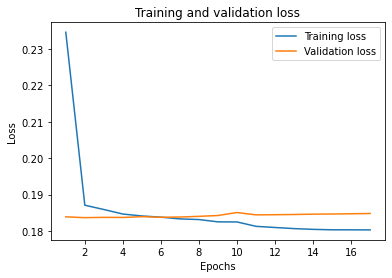

In [275]:

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();


In [277]:
# Reading in saved test cleansed text as a list
test_cleansed_text = []
# open file and read the cleansed texts
with open('test_cleansed_text.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()
    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]
        # add item to the list
        test_cleansed_text.append(current_place)

In [296]:

encoded_parler_x_holdout = tokenizer.texts_to_sequences(parler_x_holdout)
enc_parler_x_holdout = pad_sequences(encoded_parler_x_holdout, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
parler_holdout_preds = model_parler.predict(enc_parler_x_holdout)

encoded_input = tokenizer.texts_to_sequences(test_cleansed_text)
enc_data = pad_sequences(encoded_input, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
test_preds = model_parler.predict(enc_data)



In [297]:
print("AUC      {:10.4f}".format(calc_auc(test_y,test_preds)))
print("Log Loss {:10.4f}".format(calc_loss(test_y,test_preds)))
roc_auc_score_multiclass(test_y,test_preds)

AUC          0.4767
Log Loss     0.1499


{'toxic': 0.5059185292748082,
 'severe_toxic': 0.44770770585880115,
 'obscene': 0.45158146652049985,
 'threat': 0.4956968263532289,
 'insult': 0.5174181871309163,
 'identity_hate': 0.4417973762998888}

#### Everything seems to be toxic in this set

so only one class was found, hence inability to calculate metrics

In [298]:
#print("AUC      {:10.4f}".format(calc_auc(parler_y_holdout,parler_holdout_preds)))
#print("Log Loss {:10.4f}".format(calc_loss(parler_y_holdout,parler_holdout_preds)))
roc_auc_score_multiclass(parler_y_holdout,parler_holdout_preds)

{'toxic': 0,
 'severe_toxic': 0.5259754028837998,
 'obscene': 0.48832311837508147,
 'threat': 0.9517045454545454,
 'insult': 0.5112672859620966,
 'identity_hate': 0.41240925900561565}

## WIP:
- Tuning of new model with additional data - drastically reduced test set performance
- Evaluation of parler-threshold holdout set of ~21k records. Testing hypothesis of whether additional toxic components are found
- Use of textgenrnn for further data augmentation of test set

### text gen

In [ ]:
from tensorflow.keras import *

In [ ]:
from textgenrnn import textgenrnn

In [ ]:
df2 = pd.read_csv('out.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['post_text'])
# cleansed_post_text = df2.apply(lambda x: clean_text(x.post_text), axis=1)


In [ ]:
# define empty list
cleansed_post_text = []
# open file and read the cleansed texts
with open('text_files/cleansed_parler.txt', 'r', encoding="utf-8") as filehandle:
    filecontents = filehandle.readlines()

    for line in filecontents:
        # remove linebreak which is the last character of the string
        current_place = line[:-1]

        # add item to the list
        cleansed_post_text.append(current_place)
        

In [ ]:
textgen = textgenrnn()

In [ ]:
textgen.train_on_texts(list(cleansed_post_text),num_epochs=50, batch_size=512)

In [ ]:
textgen.save('models/parler-hybridgpu-V0.1.hdf5')

In [ ]:
textgen.load("models/parler-gen-V0.1.hdf5")

textgen.generate()

In [ ]:
for i in range(3,20):
    temp = (i)*0.05
    print('Generating samples at temp: ', temp)
    textgen.generate(1, temperature=temp, max_gen_length =300  )